In [51]:
import os
import re
import json
import math
import scipy
import statistics
import numpy as np 
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu, ranksums, rankdata
from autorank import autorank, plot_stats, create_report

In [52]:
runs = [9, 10, 11]
methods = ['random', 'state', 'trace']
slice_ = 5971

ratis_cov = {
    "random": [],
    "state": [],
    "trace": [],
}

# rev_map = {
#     "random": "Random",
#     "state": "ModelFuzz",
#     "trace": "Trace",
# }

for run in runs:
    for method in ratis_cov.keys():
        basedir = f'../experiments/raft_3_3/{method}/output{run}/'
        with open(os.path.join(basedir, f'saved/{method}_stats.pkl'), 'rb') as f:
            stats = pkl.load(f)
        ratis_cov[method].append(stats["coverage"][:slice_][-1])
        # print(f'Length: {len(stats["coverage"])}')
        # print(f'Coverage: {stats["coverage"][:slice_][-1]}')
ratis_cov['tlc'] = ratis_cov.pop('state')
print(ratis_cov)

{'random': [4057, 4465, 4245], 'trace': [3671, 3683, 3688], 'tlc': [4324, 4185, 4439]}


In [53]:
runs = [("cov_data/redis",i) for i in range(6)]
redis_cov = {
    "random": [],
    "tlc": [],
    "trace": [],
    "line": [],
}

for (folder, r) in runs:
    with open(os.path.join(folder, str(r)+"_data.json")) as data_file:
        d = json.load(data_file)
        for algo in d:
            redis_cov[algo].append(d[algo]["Coverages"][-1])
print(redis_cov)        

{'random': [2355, 2359, 2291, 2027, 2139, 2049], 'tlc': [5706, 4636, 6396, 6610, 5610, 4800], 'trace': [2223, 2099, 1985, 1930, 1917, 1849], 'line': [2002, 2152, 2220]}


In [54]:
with open('cov_data/etcd.json') as f:
    etcd_results = json.load(f)

etcd_cov = {
    "tlcstate": [],
    "lineCov": [],
    "traceCov": [],
    "random": []
}

for method in etcd_cov.keys():
    for cov in etcd_results[method]['coverages']:
        etcd_cov[method].append(cov[-1])

etcd_cov['tlc'] = etcd_cov.pop('tlcstate')
etcd_cov['line'] = etcd_cov.pop('lineCov')
etcd_cov['trace'] = etcd_cov.pop('traceCov')
etcd_cov

{'random': [3693, 3644, 3736, 3707, 3756],
 'tlc': [4475, 4498, 4365, 4789, 4380],
 'line': [3670, 3711, 3773, 3804, 3746],
 'trace': [2064, 1922, 1976, 1960, 2104]}

In [55]:
# Ratis M-W u tests
print('Ratis:')
ratis_p_vals = {}
for method in ratis_cov.keys():
    if method == 'tlc':
        continue
    else:
        stat, p = mannwhitneyu(ratis_cov['tlc'], ratis_cov[method])
        ratis_p_vals[method] = p
        print(f'P-value for M-W u test with ModelFuzz and {method}: {p}')

print('Redisraft:')
# Redis M-W u tests
redis_p_vals = {}
for method in redis_cov.keys():
    if method == 'tlc':
        continue
    elif method == 'line':
        stat, p = mannwhitneyu(redis_cov['tlc'], redis_cov[method])
        redis_p_vals[method] = p
        print(f'P-value for M-W u test with ModelFuzz and {method}: {p}')
    else:
        stat, p = mannwhitneyu(redis_cov['tlc'], redis_cov[method])
        redis_p_vals[method] = p
        print(f'P-value for M-W u test with ModelFuzz and {method}: {p}')

print('Etcd:')
# Etcd M-W u tests
etcd_p_vals = {}
for method in etcd_cov.keys():
    if method == 'tlc':
        continue
    else:
        stat, p = mannwhitneyu(etcd_cov['tlc'], etcd_cov[method])
        etcd_p_vals[method] = p
        print(f'P-value for M-W u test with ModelFuzz and {method}: {p}')


Ratis:
P-value for M-W u test with ModelFuzz and random: 1.0
P-value for M-W u test with ModelFuzz and trace: 0.1
Redisraft:
P-value for M-W u test with ModelFuzz and random: 0.0021645021645021645
P-value for M-W u test with ModelFuzz and trace: 0.0021645021645021645
P-value for M-W u test with ModelFuzz and line: 0.023809523809523808
Etcd:
P-value for M-W u test with ModelFuzz and random: 0.007936507936507936
P-value for M-W u test with ModelFuzz and line: 0.007936507936507936
P-value for M-W u test with ModelFuzz and trace: 0.007936507936507936


In [56]:
# Ratis M-W u tests
print('Ratis:')
ratis_p_vals = {}
for method in ratis_cov.keys():
    if method == 'tlc':
        continue
    else:
        stat, p = ranksums(ratis_cov['tlc'], ratis_cov[method])
        ratis_p_vals[method] = p
        print(f'P-value for M-W u test with ModelFuzz and {method}: {p}')

print('Redisraft:')
# Redis M-W u tests
redis_p_vals = {}
for method in redis_cov.keys():
    if method == 'tlc':
        continue
    elif method == 'line':
        stat, p = ranksums(redis_cov['tlc'], redis_cov[method])
        redis_p_vals[method] = p
        print(f'P-value for M-W u test with ModelFuzz and {method}: {p}')
    else:
        stat, p = ranksums(redis_cov['tlc'], redis_cov[method])
        redis_p_vals[method] = p
        print(f'P-value for M-W u test with ModelFuzz and {method}: {p}')

print('Etcd:')
# Etcd M-W u tests
etcd_p_vals = {}
for method in etcd_cov.keys():
    if method == 'tlc':
        continue
    else:
        stat, p = ranksums(etcd_cov['tlc'], etcd_cov[method])
        etcd_p_vals[method] = p
        print(f'P-value for M-W u test with ModelFuzz and {method}: {p}')

Ratis:
P-value for M-W u test with ModelFuzz and random: 0.8272593465627113
P-value for M-W u test with ModelFuzz and trace: 0.049534613435626706
Redisraft:
P-value for M-W u test with ModelFuzz and random: 0.003947751856903457
P-value for M-W u test with ModelFuzz and trace: 0.003947751856903457
P-value for M-W u test with ModelFuzz and line: 0.02013675155034634
Etcd:
P-value for M-W u test with ModelFuzz and random: 0.009023438818080326
P-value for M-W u test with ModelFuzz and line: 0.009023438818080326
P-value for M-W u test with ModelFuzz and trace: 0.009023438818080326


In [57]:
def ranksum(A:list, B:list, max_iters):
    # A and B are lists containing the first buggy iterations of all experiments for 2 different fuzzers
    data = A + B
    ranked_data = rankdata(list(map(lambda x: max_iters - x, data)))
    ranks = {}
    for i, d in enumerate(data):
        ranks[d] = ranked_data[i]
    return sum([ranks[e] for e in A])

def a_hat_12(A, B, max_iters):
    # m and n are the lenght of A and B
    m = len(A)
    n = len(B)
    return ((ranksum(A, B, max_iters) / m) - ((m+1) / 2)) / n

In [58]:
def rank_data(A, B):
    data = A + B
    ranked_data = rankdata(data)
    ranks = {}
    for i, d in enumerate(data):
        ranks[d] = ranked_data[i]
    return [ranks[e] for e in A], [ranks[e] for e in B]

def D_r_W(A, B, max_iters):
    r1, r2 = rank_data(A, B)
    sd_r1 = statistics.stdev(r1) if len(r1) > 1 else 0
    sd_r2 = statistics.stdev(r2) if len(r2) > 1 else 0

    return np.sqrt(((np.square(sd_r1)/len(A))+(np.square(sd_r2)/len(B))))

def calc_ci(A, B, max_iters):
    a_12 = a_hat_12(A, B, max_iters)
    d_r_w = D_r_W(A, B, max_iters)
    t = np.round(scipy.stats.t.interval(0.95, (len(A) + len(B) - 1)), decimals=3)[1]
    ci_0 = a_12 - (t * d_r_w / (len(A) + len(B)))
    ci_1 = a_12 + (t * d_r_w / (len(A) + len(B)))
    return (ci_0, ci_1)

In [59]:
with open('bug_stats.json') as f:
    redis_bugs = json.load(f)
redis_bugs

bug_identifiers = {
    1 : "raft_get_entry_from_idx",
    2 : "raft_append_entry",
    3 : "raft_restore_log",
    4 : "ConnIsConnected",
    5 : "raft_apply_entry",
    6 : "clientsCron",
    7 : "raft_delete_entry_from_idx",
    8 : "raft_node_set_snapshot_offset",
    9 : "handleBeforeSleep",
    10 : "raft_become_follower",
    11 : "raft_become_follower_requestvote_response",
    12 : "raft_set_current_term_appendentries",
    13 : "raft_set_current_term_requestvote",
    14 : "raft_set_current_term_requestvote_response"
}

methods = ['tlc', 'trace', 'random', 'line']
method_map = {
    'tlc': 'ModelFuzz',
    'trace': 'Trace',
    'random': 'Random',
    'line': 'Line'
}

for new_key, old_key in bug_identifiers.items():
    redis_bugs[new_key] = redis_bugs.pop(old_key)

stats = {}
index = 0
ci = 0.95
for key in redis_bugs.keys():
    data = redis_bugs[key]['first_occur']
    if 'tlc' not in data.keys():
        pass
        # for method in methods:
        #     if method in data.keys():
        #         stats[index] = {'Bug': key, 'A': 'ModelFuzz', 'B': method_map[method], 'P': 0.0, 'Significance': False}
        #         index += 1
    elif 'tlc' in data.keys() and len(data.keys()) == 1:
        pass
        # for method in methods:
        #     if method != 'tlc':
        #         stats[index] = {'Bug': key, 'A': 'ModelFuzz', 'B': method_map[method], 'P': 0.0, 'Significance': True}
        #         index += 1
    else:
        for method in methods:
            if method != 'tlc' and method in data.keys():
                A = list(dict(sorted(data.items()))['tlc'].values())
                B = list(dict(sorted(data.items()))[method].values())
                # A = list(map(lambda x: 20000 - x, A))
                # B = list(map(lambda x: 20000 - x, B))

                stat, p = scipy.stats.mannwhitneyu(A, B)             
                stats[index] = {'Bug': key, 'A': 'ModelFuzz', 'B': method_map[method], 'P': p, 'Significance': p <= 0.5}
                index += 1

df = pd.DataFrame(stats).T.sort_values('Bug', ascending=True).reset_index(drop=True)
df

,Bug,A,B,P,Significance
0,1,ModelFuzz,Trace,0.978418,False
1,1,ModelFuzz,Random,0.144059,True
2,1,ModelFuzz,Line,0.703172,False
3,2,ModelFuzz,Trace,0.467472,True
4,2,ModelFuzz,Random,0.213586,True
5,2,ModelFuzz,Line,0.3048,True
6,3,ModelFuzz,Trace,0.473315,True
7,3,ModelFuzz,Random,0.171547,True
8,3,ModelFuzz,Line,0.562373,False
9,4,ModelFuzz,Trace,0.498659,True


In [60]:
print(f'For all experiments with different parameter values, {len(df[df.Significance])} out of {len(df)} tests were significant at alpha level 0.05')

For all experiments with different parameter values, 10 out of 29 tests were significant at alpha level 0.05


In [61]:
with open('bug_stats.json') as f:
    redis_bugs = json.load(f)
redis_bugs

bug_identifiers = {
    1 : "raft_get_entry_from_idx",
    2 : "raft_append_entry",
    3 : "raft_restore_log",
    4 : "ConnIsConnected",
    5 : "raft_apply_entry",
    6 : "clientsCron",
    7 : "raft_delete_entry_from_idx",
    8 : "raft_node_set_snapshot_offset",
    9 : "handleBeforeSleep",
    10 : "raft_become_follower",
    11 : "raft_become_follower_requestvote_response",
    12 : "raft_set_current_term_appendentries",
    13 : "raft_set_current_term_requestvote",
    14 : "raft_set_current_term_requestvote_response"
}

methods = ['tlc', 'trace', 'random', 'line']
method_map = {
    'tlc': 'ModelFuzz',
    'random': 'Random',
    'trace': 'Trace',
    'line': 'Line'
}

for new_key, old_key in bug_identifiers.items():
    redis_bugs[new_key] = redis_bugs.pop(old_key)

stats = {}
index = 0
ci = 0.6
for key in redis_bugs.keys():
    data = redis_bugs[key]['first_occur']
    if 'tlc' not in data.keys():
        for method in methods:
            if method in data.keys():
                stats[index] = {'Bug': key, 'A': 'ModelFuzz', 'B': method_map[method], 'Statistic': 0.0, 'Significance': False, 'Cl' : 0.0, 'Cu': 1.0}
                index += 1
            else:
                stats[index] = {'Bug': key, 'A': 'ModelFuzz', 'B': method_map[method], 'Statistic': None, 'Significance': False, 'Cl' : 0.0, 'Cu': 1.0}
                index += 1
    elif 'tlc' in data.keys() and len(data.keys()) == 1:
        for method in methods:
            if method != 'tlc':
                stats[index] = {'Bug': key, 'A': 'ModelFuzz', 'B': method_map[method], 'Statistic': 1.0, 'Significance': True, 'Cl' : 0.0, 'Cu': 1.0}
                index += 1
    else:
        for method in methods:
            if method != 'tlc' and method in data.keys():
                A = list(dict(sorted(data.items()))['tlc'].values())
                B = list(dict(sorted(data.items()))[method].values())

                stat = a_hat_12(A, B, 20000)
                cis = calc_ci(A, B, 20000)
                stats[index] = {'Bug': key, 'A': 'ModelFuzz', 'B': method_map[method], 'Statistic': stat, 'Significance': stat >= ci, 'Cl' : cis[0], 'Cu': cis[1]}
                index += 1
            elif method != 'tlc':
                stats[index] = {'Bug': key, 'A': 'ModelFuzz', 'B': method_map[method], 'Statistic': 1.0, 'Significance': True, 'Cl' : 0.0, 'Cu': 1.0}
                index += 1

df = pd.DataFrame(stats).T.sort_values('Bug', ascending=True).reset_index(drop=True)
df = df[df.A != df.B]
df

,Bug,A,B,Statistic,Significance,Cl,Cu
0,1,ModelFuzz,Trace,0.50375,False,0.31436,0.69314
1,1,ModelFuzz,Random,0.36375,False,0.17971,0.54779
2,1,ModelFuzz,Line,0.461765,False,0.263814,0.659716
3,2,ModelFuzz,Trace,0.412121,False,0.160492,0.66375
4,2,ModelFuzz,Random,0.641026,True,0.417111,0.86494
5,2,ModelFuzz,Line,0.373333,False,0.120357,0.62631
6,3,ModelFuzz,Trace,0.4325,False,0.244459,0.620541
7,3,ModelFuzz,Random,0.3725,False,0.18794,0.55706
8,3,ModelFuzz,Line,0.442647,False,0.243716,0.641578
9,4,ModelFuzz,Random,0.558824,False,0.355886,0.761761


In [62]:
print(f'For all experiments with different parameter values, {len(df[df.Significance])} out of {len(df)} tests were significant at alpha level 0.05')

For all experiments with different parameter values, 17 out of 42 tests were significant at alpha level 0.05


In [63]:
with open('bug_stats.json') as f:
    redis_bugs = json.load(f)
redis_bugs

bug_identifiers = {
    1 : "raft_get_entry_from_idx",
    2 : "raft_append_entry",
    3 : "raft_restore_log",
    4 : "ConnIsConnected",
    5 : "raft_apply_entry",
    6 : "clientsCron",
    7 : "raft_delete_entry_from_idx",
    8 : "raft_node_set_snapshot_offset",
    9 : "handleBeforeSleep",
    10 : "raft_become_follower",
    11 : "raft_become_follower_requestvote_response",
    12 : "raft_set_current_term_appendentries",
    13 : "raft_set_current_term_requestvote",
    14 : "raft_set_current_term_requestvote_response"
}

methods = ['tlc', 'trace', 'random', 'line']
method_map = {
    'tlc': 'ModelFuzz',
    'random': 'Random',
    'trace': 'Trace',
    'line': 'Line'
}
max_iter = 20000

for new_key, old_key in bug_identifiers.items():
    redis_bugs[new_key] = redis_bugs.pop(old_key)

results = {}
for key in redis_bugs.keys():
    avg = redis_bugs[key]['avg_first_occur']
    
    for method in method_map.keys():
        if method not in results.keys():
            results[method] = []
        
        if method not in avg.keys():
            results[method].append(max_iter)
        else:
            results[method].append(avg[method])
bug_results = np.array([results[method] for method in method_map.keys()]).T
names = list(method_map.values())
bug_results = pd.DataFrame(bug_results, columns=names)
bug_results


,ModelFuzz,Random,Trace,Line
0,299.850000,227.200000,368.150000,256.058824
1,10409.400000,13420.615385,8518.727273,7592.000000
2,48.550000,19.800000,32.100000,43.529412
3,10255.058824,12823.055556,11600.444444,10581.571429
4,578.550000,696.850000,945.250000,482.705882
5,8334.000000,20000.000000,20000.000000,17784.000000
6,6925.000000,14345.750000,20000.000000,6512.500000
7,20000.000000,20000.000000,16275.000000,20000.000000
8,11155.062500,12449.250000,12766.692308,15157.692308
9,11748.000000,6598.666667,18001.000000,9680.000000


RankResult(rankdf=
           meanrank          mean          std     ci_lower      ci_upper  \
ModelFuzz  3.071429   7494.212237  5742.497305  3922.259579  11066.164896   
Line       2.571429  11453.662863  7675.024435  7881.710204  15025.615521   
Random     2.321429  11889.656258  7377.120915  8317.703599  15461.608916   
Trace      2.035714  12625.901002  7520.322891  9053.948343   16197.85366   

          effect_size   magnitude  
ModelFuzz         0.0  negligible  
Line        -0.584163      medium  
Random      -0.664916      medium  
Trace       -0.766986      medium  
pvalue=0.007888622204996913
cd=None
omnibus=anova
posthoc=tukeyhsd
all_normal=True
pvals_shapiro=[0.21716897189617157, 0.019030651077628136, 0.05854208767414093, 0.02959515154361725]
homoscedastic=True
pval_homogeneity=0.7352604090233299
homogeneity_test=bartlett
alpha=0.05
alpha_normality=0.0125
num_samples=14
posterior_matrix=
None
decision_matrix=
None
rope=None
rope_mode=None
effect_size=cohen_d
force_mode=N

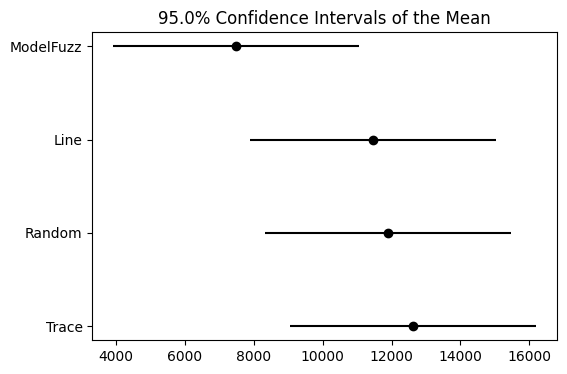

In [64]:
result = autorank(bug_results, alpha=0.05, verbose=False)
print(result)
create_report(result)
plot_stats(result)
plt.savefig('figures/redisraft_tukey.eps')